# Brands and products emotion dataset analisys 

In [299]:
#Importing important stuff
import nltk
import sklearn
import string
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
#weee

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [239]:
#Loading in dataset
path_to_dataset = 'tweets.csv'
df = pd.read_csv(path_to_dataset, dtype=str)

In [240]:
df = df.rename(columns = {'emotion_in_tweet_is_directed_at':'products', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotions'})
df = df.set_index('index')

## Entry analisys

In [241]:
df.describe()

,tweet_text,products,emotions
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [242]:
df.head()

,tweet_text,products,emotions
index,,,
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<AxesSubplot:ylabel='emotions'>

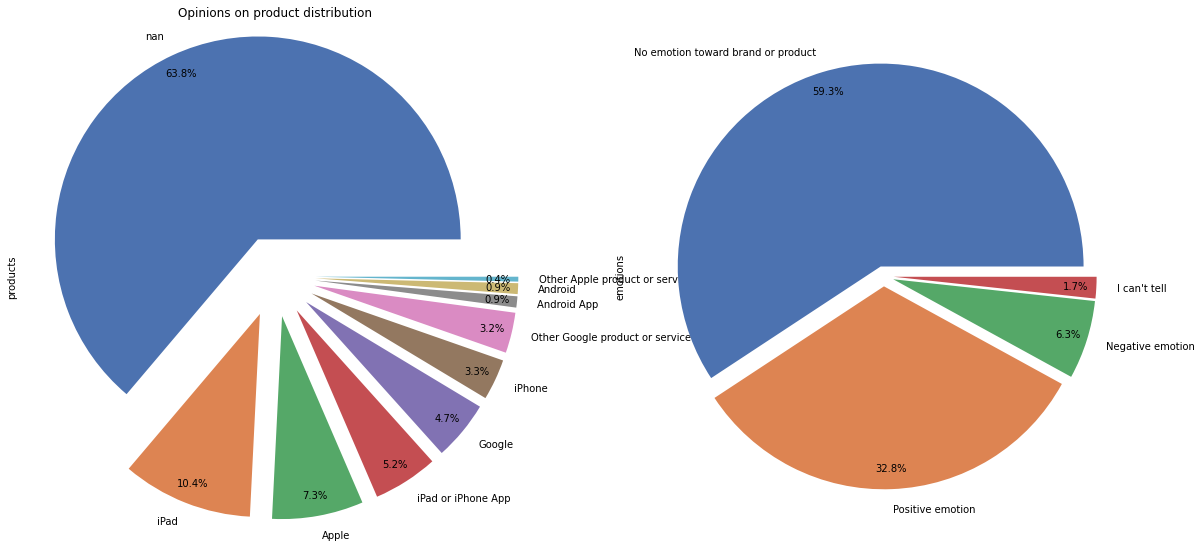

In [243]:
products= df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

distance = [0.2 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,2,1)
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)
ax.set_title('Opinions on product distribution')

fig.add_subplot(1,2,2)
ax3 = df.emotions.value_counts(dropna=False)
distanceEmotions = [0.05 for i in ax3]
ax3.plot.pie(autopct='%1.1f%%', colors=colors, explode=distanceEmotions, grid=False, pctdistance=0.90)

As we can see, there is a lot of unassigned data, in both emotions and products columns. Because of that, we have unbalanced data – meaning there is an overwhelming amount of one feature in the dataset. 
If we would try to train a neural network on unbalanced data, we would overfit the network to classify most of the occurrences of the dominant feature.
 
What can we do to prevent such a thing? We can balance our data set. Basically, in this case we try to match the size of the smallest feature in our data set. In the case of the 'Emotions' column that would mean to fit the size of 'Positive emotion' to the size of 'Negative emotion'. Quick math: 6.3% of 9093 is 572, which means that we should only use 572 examples from 'Positive Emotions' (we don't want to use 'No Emotions' because this won't help us with determinating if a tweet is positive or negative, neither 'Can't tell' column will help us with this task).

In [244]:
throw_away = df.loc[df.emotions.isin(["No emotion toward brand or product","I can't tell"])].index
df.drop(throw_away, inplace=True)

emotions_count = df.emotions.value_counts()
procentage = int(100 - (emotions_count[1]*100)/emotions_count[0]) * 0.01

positive_emotion  = df.loc[df['emotions'] == "Positive emotion"]
index_possitive = positive_emotion.sample(frac=procentage).index
df.drop(index_possitive, inplace=True)

In [245]:
df.describe()

,tweet_text,products,emotions
count,1166,1041,1166
unique,1165,9,2
top,I just noticed DST is coming this weekend. How...,iPad,Positive emotion
freq,2,285,596


<AxesSubplot:ylabel='emotions'>

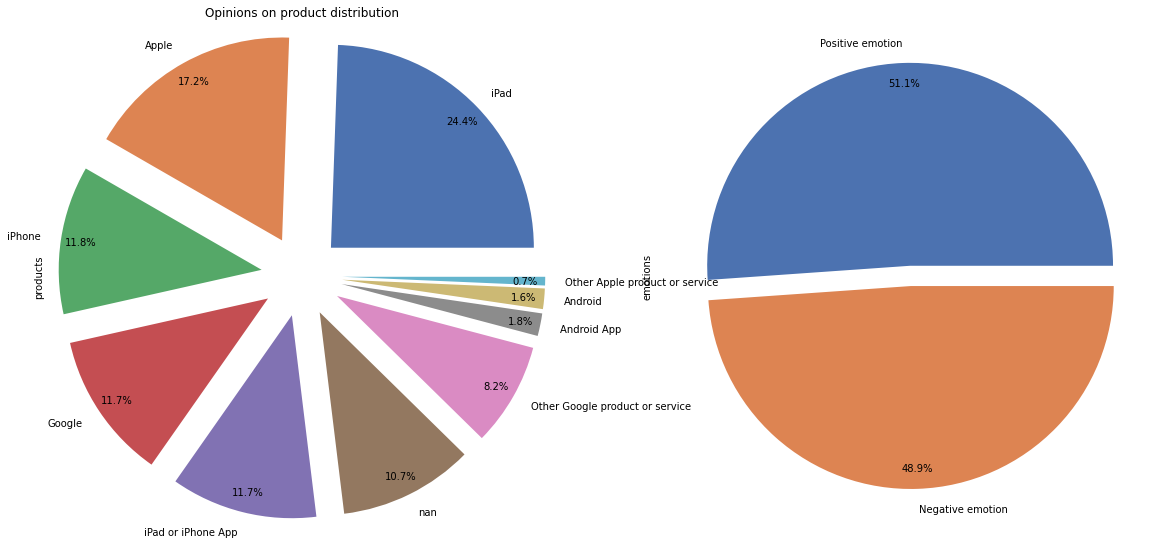

In [246]:
products=df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

distance = [0.2 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,2,1)
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)
ax.set_title('Opinions on product distribution')

fig.add_subplot(1,2,2)
ax3 = df.emotions.value_counts(dropna=False)
distanceEmotions = [0.05 for i in ax3]
ax3.plot.pie(autopct='%1.1f%%', colors=colors, explode=distanceEmotions, grid=False, pctdistance=0.90)

## Text normalization

In [247]:
df.tweet_text = df.tweet_text.astype(str)

In [248]:
df.tweet_text = df.tweet_text.apply(lambda x: x.lower())

In [249]:
def cleanseText(textColumn):
    textColumn = textColumn.apply(lambda x: x.lower())
    textColumn = textColumn.apply(lambda x: re.sub(".iphone.|.ipad.|.google.|.app.","",x))
    textColumn = textColumn.apply(lambda x: re.sub("@\w+","",x))
    textColumn = textColumn.apply(lambda x: re.sub(r'\w*\d+\w*','',x))
    textColumn = textColumn.apply(lambda x: re.sub(r'{link}','',x))
    textColumn = textColumn.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    textColumn = textColumn.apply(lambda x: x.strip())
    textColumn = textColumn.apply(lambda x: re.sub("sxsw","",x))

    return textColumn

In [250]:
def tokenization(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokenized = [i for i in tokens if i not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    
    return " ".join(lemmatized)

In [251]:
def oneHotVector(emotion):
    if emotion == "Positive emotion":
        return 1
    else:
        return 0

In [252]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('nor')
stop_words.remove('no')

lemmatizer= nltk.stem.WordNetLemmatizer()

df["tweet_text"] = cleanseText(df.tweet_text)
df["tokenized"] = df["tweet_text"].apply(tokenization)
df["oneHotVectors"] = df["emotions"].apply(oneHotVector)

In [288]:
data, oneHot = df.tweet_text.to_numpy(), df.oneHotVectors.to_numpy()
data, oneHot = tf.convert_to_tensor(data), tf.convert_to_tensor(oneHot)
procent = int(data.shape[0] * .7)
train_data = data[:procent], oneHot[:procent]
test_data = data[procent:], data[procent:]

In [304]:
test_data[0].dtype

tf.string